In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import metrics
from datetime import date


In [25]:
# Training Dataset
# expedia = pd.read_csv('../Final_Project/data/train.csv',nrows=500000)
expedia = pd.read_csv('../Final_Project/data/train.csv',nrows=175000)

In [26]:
print 'Expedia Site Dataframe Shape'
print expedia.shape

Expedia Site Dataframe Shape
(175000, 24)


In [27]:
# Add features that are added when training
# Prep Expedia Train Dataset 
# Add a column for the epoch time to dataset. 
# Need to do this before time is changed from a string to a date time
import time, os
# search time epoch
epochs = []
d = expedia.date_time
p='%Y-%m-%d %H:%M:%S'
for dts in d:
    epoch = int(time.mktime(time.strptime(dts,p)))
    epochs.append(epoch)
expedia['search_time_epoch'] = epochs


# time on site column
# using time the user first searched as t0. i.e. 0 time = first search
expedia['tos'] = expedia.search_time_epoch
user = expedia.user_id
for u in user: 
    t0 = min(expedia.loc[expedia.user_id == u].search_time_epoch)
    expedia.loc[expedia['user_id']==u,'tos'] = expedia.search_time_epoch - t0


In [28]:
book = expedia['is_booking'] == 1
# Select all cases where stark is the attacker and the attacker wins
expedia_booked = expedia[book]

# expedia = expedia[expedia.is_booking == 1]
# expedia = expedia.loc[expedia.is_booking == 1]
print 'Expedia Training when isbooking = 1'
print expedia_booked.shape

Expedia Training when isbooking = 1
(14510, 26)


In [29]:
# user IDs. 
print 'Dataset Stats'
print 'Size of Dataframe', expedia.shape

# unique User counts. 
user = expedia.groupby('user_id').user_id.count()
muser = user.mean()
print 'Unique Users: ', len(user)
print 'Mean entries per user: ', muser

# Number of bookings vs. other entries. 
lbook = len(expedia.loc[(expedia['is_booking']  == 1)])
num_book = expedia.groupby('is_booking').is_booking.count()
print 'Number of entries where users book', lbook, 'total', len(expedia)

# unique hotel cluster counts. 
hc = expedia.groupby('hotel_cluster').hotel_cluster.count()
print 'Unique Hotel Cluster IDs: ', len(hc)

# unique hotel cluster counts. 
hc = expedia.groupby('hotel_continent').hotel_cluster.count()
print 'Unique Hotel Continents IDs: ', len(hc)

# unique hotel cluster counts. 
hc = expedia.groupby('hotel_country').hotel_cluster.count()
print 'Unique Hotel Country IDs: ', len(hc)

# unique hotel cluster counts. 
hc = expedia.groupby('hotel_market').hotel_cluster.count()
print 'Unique Hotel Market IDs: ', len(hc)

Dataset Stats
Size of Dataframe (175000, 26)
Unique Users:  5996
Mean entries per user:  29.1861240827
Number of entries where users book 14510 total 175000
Unique Hotel Cluster IDs:  100
Unique Hotel Continents IDs:  6
Unique Hotel Country IDs:  170
Unique Hotel Market IDs:  1727


In [30]:
# unique User counts. 
user = expedia_booked.groupby('user_id').user_id.count()
muser = user.mean()
print 'Unique Users: ', len(user)
print 'Mean entries per user: ', muser

# unique hotel cluster counts. 
hc = expedia_booked.groupby('hotel_cluster').hotel_cluster.count()
print 'Unique Hotel Cluster IDs: ', len(hc)

# unique hotel cluster counts. 
hc = expedia_booked.groupby('hotel_continent').hotel_cluster.count()
print 'Unique Hotel Continents IDs: ', len(hc)

# unique hotel cluster counts. 
hc = expedia_booked.groupby('hotel_country').hotel_cluster.count()
print 'Unique Hotel Country IDs: ', len(hc)

# unique hotel cluster counts. 
hc = expedia_booked.groupby('hotel_market').hotel_cluster.count()
print 'Unique Hotel Market IDs: ', len(hc)


Unique Users:  3994
Mean entries per user:  3.63294942414
Unique Hotel Cluster IDs:  100
Unique Hotel Continents IDs:  6
Unique Hotel Country IDs:  140
Unique Hotel Market IDs:  1299


In [31]:
# Add features 
# define function to find the day of the week. 
# Monday = 1, Sunday = 7
def find_dow(date_col):
    dow = []
    for d in date_col: 
        dow.append(d.isoweekday()) 
    return dow


# Adding Time Feature columns to Dataset 

# Replacing NaN/None values in check in and out search. 
expedia_booked['srch_ci'] = np.where(pd.isnull(expedia_booked.srch_ci) == 1, 0, expedia_booked.srch_ci)
expedia_booked['srch_co'] = np.where(pd.isnull(expedia_booked.srch_co) == 1, 0, expedia_booked.srch_co)

expedia_booked['date_time'] = pd.to_datetime(expedia['date_time'])
expedia_booked['year'] = expedia_booked['date_time'].dt.year
expedia_booked['month'] = expedia_booked['date_time'].dt.month
expedia_booked['day'] = expedia_booked['date_time'].dt.day

# -------------------
# Adding Day of the week the search occured
# Monday = 1, Sunday = 7
date_time = expedia_booked.date_time
dow = find_dow(date_time)
expedia_booked['dow_search'] = dow

# -------------------
# Adding Day of the week check-in date
expedia_booked['srch_ci'] = pd.to_datetime(expedia_booked['srch_ci'])
date_ci = expedia_booked.srch_ci
dow = find_dow(date_ci)
expedia_booked['dow_ci'] = dow

# -------------------
# Adding Day of the week check-out date
expedia_booked['srch_co'] = pd.to_datetime(expedia_booked['srch_co'])
date_co = expedia_booked.srch_co
dow = find_dow(date_co)
expedia_booked['dow_co'] = dow

# -------------------
# length of stay in days
delta = date_co - date_ci
los = np.zeros(len(delta))
c = 0
for d in delta:
    los[c] = d.days
    c += 1    
expedia_booked['length_of_stay'] = los

# Adding feature columns to dataset. 

# if there are children - making a binary column of family
is_family = np.where(expedia_booked.srch_children_cnt >= 1, 1, 0)
expedia_booked['is_family'] = is_family

# expedia.head(2)

/Users/mcullen/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/mcullen/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/mcullen/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/

In [32]:
# add features from detinations csv

destinations = pd.read_csv('../Final_Project/data/destinations.csv') 

# Prep Destinations Dataset
# Adding Mean, Meadian, stdev, is_positive columns 
d = destinations
d = d.drop('srch_destination_id',axis = 1)

destinations['mean_latent'] = np.nanmean(d, axis=1)
destinations['median_latent'] = np.nanmedian(d, axis=1)
destinations['std_latent'] = np.nanstd(destinations, axis=1)
destinations['mean_p_std_latent'] = abs(destinations.mean_latent) + destinations.std_latent
destinations['max_latent'] = np.nanmax(d, axis=1)
destinations['min_latent'] = np.nanmin(d, axis=1)
destinations['is_positive_review'] = np.where(destinations.mean_latent > 0, 1, 0)
destinations['range_latent'] = destinations.max_latent - destinations.min_latent

# use only summary columns in training. 
use = ['srch_destination_id', 'mean_latent', 'median_latent', 'std_latent',\
       'mean_p_std_latent', 'max_latent', 'min_latent','is_positive_review',\
       'range_latent']
destinations_use =  destinations[use]


# Add Destination Data Information to Expedia Dataset
# Adding by search destination ID
expedia_booked = pd.merge(expedia_booked, destinations_use, left_on='srch_destination_id', \
                   right_on='srch_destination_id', how='left')


In [10]:
# fix NaN and Null values
expedia_booked['mean_latent'] = np.where(pd.isnull(expedia_booked.mean_latent) == 1, 0, expedia_booked.mean_latent)
expedia_booked['median_latent'] = np.where(pd.isnull(expedia_booked.median_latent) == 1, 0, expedia_booked.median_latent)
expedia_booked['std_latent'] = np.where(pd.isnull(expedia_booked.std_latent) == 1, 0, expedia_booked.std_latent)
expedia_booked['mean_p_std_latent'] = np.where(pd.isnull(expedia_booked.mean_p_std_latent) == 1, 0, expedia_booked.mean_p_std_latent)
expedia_booked['max_latent'] = np.where(pd.isnull(expedia_booked.max_latent) == 1, 0, expedia_booked.max_latent)
expedia_booked['min_latent'] = np.where(pd.isnull(expedia_booked.min_latent) == 1, 0, expedia_booked.min_latent)
expedia_booked['is_positive_review'] = np.where(pd.isnull(expedia_booked.is_positive_review) == 1, 0, expedia_booked.is_positive_review)
expedia_booked['range_latent'] = np.where(pd.isnull(expedia_booked.range_latent) == 1, 0, expedia_booked.range_latent)

# print expedia_booked.shape
# expedia_booked.head(2)

In [11]:
expedia.corr()

,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,is_package,channel,...,srch_destination_id,srch_destination_type_id,is_booking,cnt,hotel_continent,hotel_country,hotel_market,hotel_cluster,search_time_epoch,tos
site_name,1.000000,-0.752035,0.112986,0.316418,0.015006,0.049022,-0.014334,-0.007864,0.121605,-0.060336,...,0.015102,-0.050096,-0.018194,0.022775,0.257505,0.238376,-0.063969,-0.020491,0.019546,-0.143933
posa_continent,-0.752035,1.000000,0.131910,-0.233619,-0.018794,-0.004432,0.024132,0.008158,-0.151142,0.088776,...,-0.008727,0.067887,0.018515,-0.019490,-0.354299,-0.174887,0.051918,0.005375,-0.035530,0.129681
user_location_country,0.112986,0.131910,1.000000,-0.002078,0.088140,0.071335,0.025857,-0.002251,-0.018215,0.078920,...,-0.007340,0.008767,0.001154,0.011235,-0.032597,0.144096,0.009159,-0.021801,-0.046674,-0.004850
user_location_region,0.316418,-0.233619,-0.002078,1.000000,0.076549,0.073536,0.035003,-0.003284,0.061807,-0.021198,...,0.013269,-0.006132,0.008323,-0.003213,0.110219,-0.016013,0.034986,0.008455,-0.031785,-0.004328
user_location_city,0.015006,-0.018794,0.088140,0.076549,1.000000,-0.015505,-0.024528,-0.017253,0.019742,0.002937,...,0.001557,-0.007595,-0.000509,-0.001468,-0.001483,-0.004008,0.007831,-0.001534,-0.011753,-0.012537
orig_destination_distance,0.049022,-0.004432,0.071335,0.073536,-0.015505,1.000000,0.038243,-0.055250,0.040058,0.017359,...,-0.008204,-0.049698,-0.041458,0.023077,0.463961,0.307099,-0.066210,0.010287,-0.012852,0.017384
user_id,-0.014334,0.024132,0.025857,0.035003,-0.024528,0.038243,1.000000,-0.003432,-0.002056,0.010151,...,0.002239,-0.003715,0.001034,0.002718,-0.031295,-0.005178,0.011125,-0.005377,-0.003617,0.019642
is_mobile,-0.007864,0.008158,-0.002251,-0.003284,-0.017253,-0.055250,-0.003432,1.000000,0.061455,-0.044357,...,-0.017738,-0.021153,-0.033813,0.003020,-0.007042,-0.024370,-0.003997,0.000351,0.044712,-0.006203
is_package,0.121605,-0.151142,-0.018215,0.061807,0.019742,0.040058,-0.002056,0.061455,1.000000,-0.024319,...,-0.147242,-0.222413,-0.078898,0.124122,0.132383,-0.008825,-0.010502,0.053075,0.004271,-0.038714
channel,-0.060336,0.088776,0.078920,-0.021198,0.002937,0.017359,0.010151,-0.044357,-0.024319,1.000000,...,0.000394,0.031821,0.027949,-0.014847,-0.020209,-0.010285,0.023361,0.000028,-0.061220,0.040442


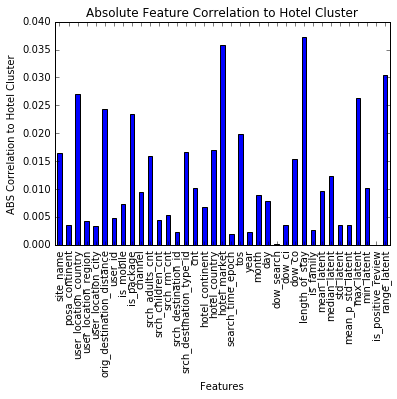

In [12]:
corrs = expedia_booked.corr()
corrs = corrs.drop(['hotel_cluster','is_booking'],axis = 0)
corrs['hotel_cluster_abs'] = corrs.hotel_cluster.abs()
# corrs = corrs.abs()
corrs.hotel_cluster_abs.plot(kind='bar', title='Absolute Feature Correlation to Hotel Cluster')
plt.xlabel('Features')
plt.ylabel('ABS Correlation to Hotel Cluster')

In [13]:
# pd.scatter_matrix(expedia_booked, figsize = (10,10))

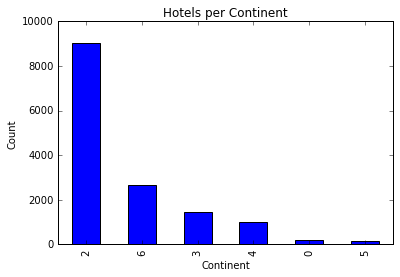

In [14]:
# bar plot of number of Hotels in each continent
expedia_booked.hotel_continent.value_counts().plot(kind='bar', title='Hotels per Continent')
plt.xlabel('Continent')
plt.ylabel('Count')

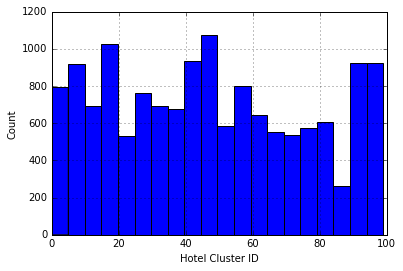

In [15]:
# histogram of beer servings
expedia_booked.hotel_cluster.hist(bins=20)
plt.xlabel('Hotel Cluster ID')
plt.ylabel('Count')

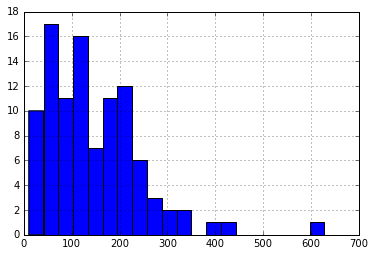

In [16]:
expedia_booked.hotel_cluster.value_counts().hist(bins=20)


In [17]:
sns.countplot(x='hotel_cluster', data=expedia_booked)

NameError: name 'sns' is not defined

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
# preferred continent destinations
sns.countplot(x='hotel_continent', data=expedia_booked)

ImportError: No module named seaborn

In [19]:
sns.countplot(x='hotel_country', data=expedia_booked)

NameError: name 'sns' is not defined

In [20]:
sns.countplot(x='hotel_market', data=expedia_booked)

NameError: name 'sns' is not defined

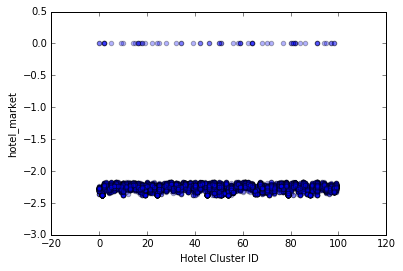

In [22]:
# scatterplot of hotel cluster  versus 
expedia_booked.plot(x='hotel_cluster', y='median_latent', kind='scatter', alpha=0.3)
plt.xlabel('Hotel Cluster ID')
plt.ylabel('hotel_market')